In [71]:
# wrapper que integra Keras (TensorFlow) com Scikit-Learn para facilitar o uso de GridSearchCV - pois antes o KerasRegressor nao esta funcionando (from keras.wrappers.scikit_learn import KerasRegressor)
!pip install scikeras

# Acessar os valores das ações, petróleo (brent), ibovespa e minério de ferro
!pip install yfinance

# Acessar a variável de entrada do fechamento do dólar
!pip install python-bcb==0.3.3 # biblioteca para

# Foi preciso dar upgrade para rodar os imports
!pip install --upgrade scikit-learn

In [72]:
## 1. Importação de Bibliotecas

# Leitura, interpretação e plotar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normalização e avaliação do modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Construção do modelo LSTM
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Bases para as variáveis de entrada (features)
import yfinance as yf
from bcb import sgs

In [73]:
## 2. Coleta dos Dados

# Datas de início e fim das features
start = '2016-01-01'
end = '2025-06-25'

# Dados da VALE3 (Close e Volume)
vale = yf.download('VALE3.SA', start=start, end=end)[['Close', 'Volume']] # filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
vale.columns = ['Close_VALE3', 'Volume_VALE3'] # renomeia a coluna

# Dólar
dolar = sgs.get({'Close_Dolar': 1}, start=start, end=end).reset_index() # faz com que Date deixe de ser index e passe a ser uma coluna junto ao Close_Dolar
dolar['Date'] = pd.to_datetime(dolar['Date']) # muda o type da coluna Date para Datetime para ficar igual as demais variáveis
dolar.set_index('Date', inplace=True) # retorna Date para index, pois é assim que as demais variáveis estão

# Petróleo (WTI) pelo Yahoo Finance
petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # preço do barril de petróleo WTI
petroleo.columns = ['Close_Petroleo']

# Ibovespa
ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # índice ibovespa
ibov.columns = ['Close_Ibovespa']

# Minério de Ferro (supondo índice internacional)
minerio = yf.download('RIO', start=start, end=end)[['Close']] # mineradora Rio Tinto
minerio.columns = ['Close_Minerio']

/tmp/ipython-input-73-3481198383.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vale = yf.download('VALE3.SA', start=start, end=end)[['Close', 'Volume']] # filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-73-3481198383.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # preço do barril de petróleo WTI
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-73-3481198383.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # índice ibovespa
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-73-3481198383.py:25: FutureWarning: YF.download() has changed argument auto_adju

In [74]:
## 3. Preparação e Merge dos Dados

# Unificar tudo em um DataFrame
df = vale.copy() # cria uma cópia do dataframe para ir dando o merge
df = df.merge(dolar, left_index=True, right_index=True, how='left') # junta os dados ao dataframe principal a partir do index (date)
df = df.merge(petroleo, left_index=True, right_index=True, how='left')
df = df.merge(ibov, left_index=True, right_index=True, how='left')
df = df.merge(minerio, left_index=True, right_index=True, how='left')

# Remover valores nulos
df.dropna(inplace=True)

In [75]:
## 4. Normalização

scaler = MinMaxScaler() # usa o minmaxscaler como normalizador para escalar os dados entre 0 e 1
dados_escalados = scaler.fit_transform(df) # aplica o normalizador a todos os dados numéricos

In [76]:
## 5. Criação da Janela Deslizante (21 dias)

def createXY(dataset, n_past): # função que cria as janelas deslizantes
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)): # começa no n_past (=21)
        dataX.append(dataset[i - n_past:i, :]) # para cada ponto no tempo, pega os últimos 'n_past' dias como entrada (X)
        dataY.append(dataset[i, 0]) # a saída (y) será o valor de fechamento da VALE3 no dia seguinte; o índice 0 representa o Close_Vale3 que vai ser a variável de saída (predição)
    return np.array(dataX), np.array(dataY)

X, y = createXY(dados_escalados, 21) # gera os arrays X (entradas) e y (saídas) com uma janela de 21 dias

# Separar treino e teste (80/20)
split = int(len(X) * 0.8) # faz o corte de 80% dos dados
X_train, X_test = X[:split], X[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> X
y_train, y_test = y[:split], y[split:] # train (treino) = 80% dos dados; test (teste) = 20% dos dados --> Y

In [77]:
## 6. Construção do Modelo com GridSearchCV (2ª arquitetura)

def build_model(optimizer='adam'): # função para criar o modelo LSTM como base para o GridSearchCV
    model = Sequential() # cria um modelo sequencial (camadas empilhadas)
    model.add(LSTM(128, return_sequences=True, input_shape=(21, X_train.shape[2]))) # primeira camada LSTM com 128 neurônios e retorno da sequência para a próxima LSTM
    model.add(Dropout(0.3)) # dropout após a primeira LSTM (evita overfitting logo na entrada)
    model.add(LSTM(64)) # segunda camada LSTM com 64 neurônios (sem return_sequences, pois é a última LSTM)
    model.add(Dense(10)) # camada densa intermediária com 10 neurônios (pode ajudar a refinar a saída)
    model.add(Dense(1)) # camada de saída com 1 neurônio (regressão: previsão de um único valor)
    model.compile(optimizer=optimizer, loss='mse') # compila o modelo com o otimizador informado e função de erro MSE (erro quadrático médio)
    return model


model = KerasRegressor(model=build_model, verbose=1) # envolve o modelo Keras dentro de um wrapper compatível com scikit-learn (necessário para o GridSearchCV)

params = { # definição dos hiperparâmetros
    'batch_size': [20, 32], # tamanhos de lote a testar
    'epochs': [20], # número de épocas de treino
    'optimizer': ['adam'] # otimizador usado na compilação
}

grid = GridSearchCV(estimator=model, param_grid=params, cv=3) # inicializa o GridSearchCV para encontrar os melhores hiperparâmetros usando validação cruzada (cv=3)
grid_result = grid.fit(X_train, y_train) # realiza o treinamento e busca dos melhores parâmetros

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - loss: 0.0437
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0026
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0017
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0015
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0016
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0024
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0013
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0013
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0016
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0012
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0012
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0013
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0015
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0388
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0019
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0017
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0017
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0017
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0011
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0010
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0013
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0012
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.1598e-04
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0010
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.5356e-04
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0204
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.3242e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.4458e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 5.9494e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.7453e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.6183e-04
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.8387e-04
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 4.3155e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.6178e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 4.3101e-04
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.5247e-04
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.9316e-04
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.4508e-04
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 4.9116e-04
Epoch 15/20
61/61 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0701
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0031
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0021
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0019
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0017
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0015
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0016
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0014
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0017
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0014
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0015
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0013
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0013
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0011
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0011
Epoch 16/20
38/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0827
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0023
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0019
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0020
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0015
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0016
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0015
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0015
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0013
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0011
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0011
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0012
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0012
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0012
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0018
Epoch 16/20
38/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0222
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0015
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 6.9860e-04
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.7583e-04
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.0004e-04
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.2279e-04
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.1516e-04
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.3630e-04
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 5.7667e-04
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.5495e-04
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.0073e-04
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.5856e-04
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.3275e-04
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 4.5853e-04
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0471
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0019
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0015
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0012
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0011
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0013
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0012
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0010
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 9.6380e-04
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 9.0105e-04
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0011
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 8.3751e-04
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0010
Epoch 14/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 8.5927e-04
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.8596

In [78]:
## 7. Avaliação do Modelo

best_model = grid_result.best_estimator_ # recupera o melhor modelo encontrado pelo GridSearchCV
pred = best_model.predict(X_test) # faz a predição dos valores do conjunto de teste

# Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1) # expande a predição para ter o mesmo número de colunas que o DataFrame original (necessário para desfazer a normalização)
y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1) # faz o mesmo com os valores reais (y_test), para poder comparar os dados reais com os previstos no mesmo formato

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0] # inverte a normalização nas previsões e pega só a 1ª coluna (preço da VALE3)
y_real = scaler.inverse_transform(y_expand)[:, 0] # inverte a normalização nos valores reais (y_test) e pega só a 1ª coluna

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [79]:
## 8. Métricas

print("MAE:", mean_absolute_error(y_real, pred_real)) # erro absoluto médio (MAE)
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real)) # erro percentual médio absoluto (MAPE)
print("R²:", r2_score(y_real, pred_real)) # R² (quanto o modelo explica da variabilidade dos dados)

MAE: 1.071023195784613
MAPE: 0.018685912837831636
R²: 0.8586766103736874


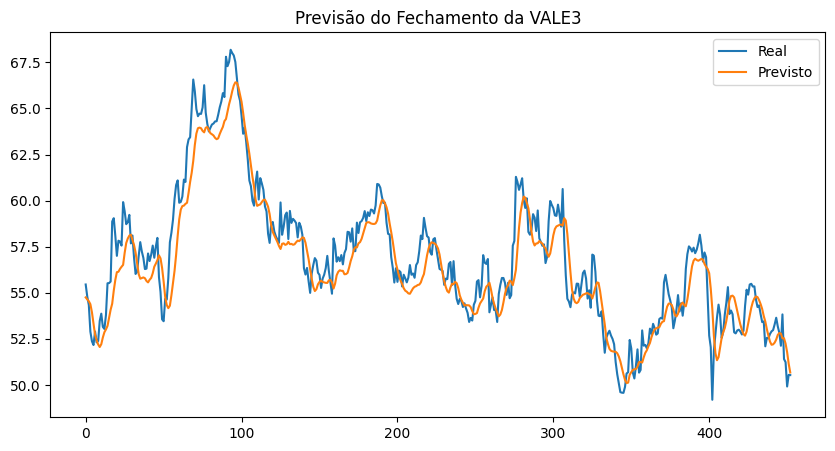

In [80]:
## 9. Gráfico

plt.figure(figsize=(10,5))
plt.plot(y_real, label='Real')
plt.plot(pred_real, label='Previsto')
plt.legend()
plt.title('Previsão do Fechamento da VALE3')
plt.show()